In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows",1000):
        with pd.option_context("display.max_columns",1000):
            display(df)

In [4]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [6]:
train=pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

In [7]:
#train.drop(train[train['Married'].isnull()].index,inplace=True)
#train.drop(train[(train['LoanAmount'].isnull()) & (train['Credit_History'].isnull())].index,inplace=True)

In [8]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
continuous_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [9]:
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

In [10]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
6,Credit_History,50,8.1433
3,Self_Employed,32,5.2117
4,LoanAmount,22,3.5831
2,Dependents,15,2.4430
5,Loan_Amount_Term,14,2.2801
0,Gender,13,2.1173
1,Married,3,0.4886


In [11]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
5,Credit_History,29,7.9019
2,Self_Employed,23,6.2670
0,Gender,11,2.9973
1,Dependents,10,2.7248
4,Loan_Amount_Term,6,1.6349
3,LoanAmount,5,1.3624


In [12]:
#train['Credit_History_Null'] = (train['Credit_History'].isnull()) * 1
#test['Credit_History_Null']  = (test['Credit_History'].isnull()) * 1

train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True) 
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)

train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train['Married'].fillna(train['Gender'].mode()[0], inplace=True)
test['Married'].fillna(test['Gender'].mode()[0], inplace=True)

In [13]:
def emi_calculator(row): 
    r = 6.0 / (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 

In [14]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [15]:
property_map = {'Rural':3,'Urban':1,'Semiurban':2}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) +1
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-(full_dataset['EMI']) +1
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']

full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']
full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)

In [16]:
full_dataset_null =get_nullframe(full_dataset)
full_dataset_null

,feature,count,null_percent
0,Loan_Status,367,37.4108


In [17]:
full_dataset.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
0,5849,0.0,1.0,0,Graduate,1,130.0,360.0,LP001002,1.0,0,1,No,5849.0,N,779.4157,5070.5843,5070.5843,44.9923,44.9923
1,4583,1508.0,1.0,1,Graduate,1,128.0,360.0,LP001003,0.0,1,3,No,6091.0,Y,767.4247,5324.5753,3816.5753,35.8047,47.5859
2,3000,0.0,1.0,0,Graduate,1,66.0,360.0,LP001005,1.0,1,1,Yes,3000.0,N,395.7033,2605.2967,2605.2967,45.4545,45.4545
3,2583,2358.0,1.0,0,Not Graduate,1,120.0,360.0,LP001006,1.0,1,1,No,4941.0,Y,719.4606,4222.5394,1864.5394,21.5250,41.1750
4,6000,0.0,1.0,0,Graduate,1,141.0,360.0,LP001008,1.0,0,1,No,6000.0,N,845.3662,5155.6338,5155.6338,42.5532,42.5532


In [18]:
cat_list = [column for column in  full_dataset.columns if column not in full_dataset.describe(include=[np.number]).columns.values.tolist()]
cat_list.remove('Loan_ID') 

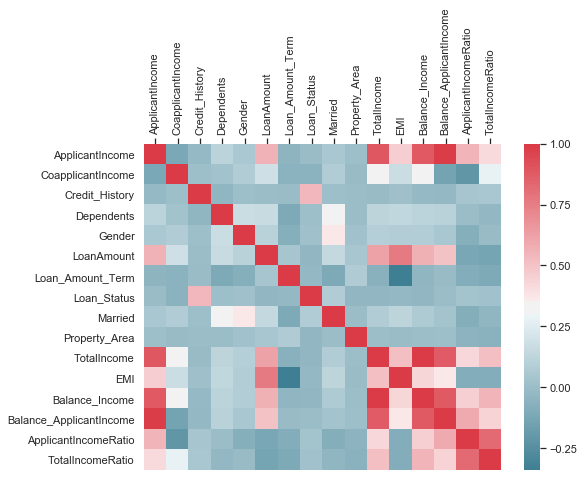

In [19]:
correlation = full_dataset[full_dataset['Loan_Status'].notnull()][full_dataset.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [20]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','CoapplicantIncome','TotalIncome', 
                   'Balance_Income','ApplicantIncome'
                   ],axis=1,inplace=True)

full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)

#from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
#scaler = LogTransformer(['EMI','LoanAmount'])
#full_dataset =scaler.fit_transform(full_dataset)

full_dataset['EMI'] = np.log1p(full_dataset['EMI'])
full_dataset['LoanAmount'] = np.log1p(full_dataset['LoanAmount'])

In [21]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)


In [22]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [23]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=1)
kfold = StratifiedKFold(n_splits=5)

(614, 14)
(367, 14)


Accuracy: 89.130


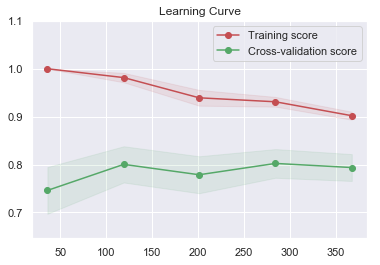

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)


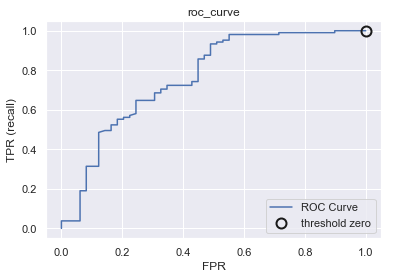

In [24]:
from xgboost.sklearn import XGBClassifier

xgbr = XGBClassifier(n_estimators=100, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

best_model ,result = test_classifier(xgbr,X_trainmodel,y_trainmodel,kfold)
print(best_model)
plot_roc(X_val,y_val,best_model)

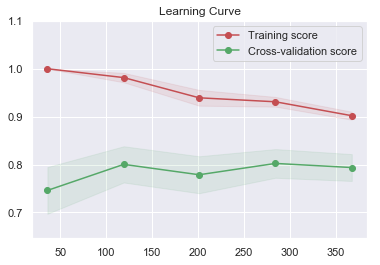

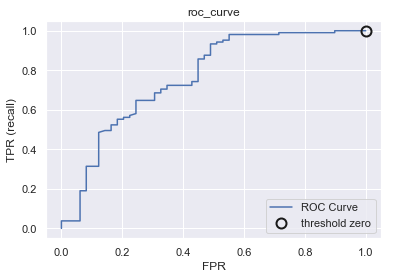

Classification report
              precision    recall  f1-score   support

         0.0       0.85      0.45      0.59        49
         1.0       0.79      0.96      0.87       105

   micro avg       0.80      0.80      0.80       154
   macro avg       0.82      0.71      0.73       154
weighted avg       0.81      0.80      0.78       154

Confusion matrix
[[ 22  27]
 [  4 101]]


In [25]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
evaluvate_model(xgbr,X_trainmodel, y_trainmodel,X_val,y_val)

In [26]:
def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [27]:
import xgboost as xgb

In [28]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 0.7,
          'colsample_bylevel': 1,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          }

num_boost_round =60

In [29]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist,
                feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.171739	eval-merror:0.201299	train-accuracy_score:0.828261	eval-accuracy_score:0.798701
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.169565	eval-merror:0.194805	train-accuracy_score:0.830435	eval-accuracy_score:0.805195
[2]	train-merror:0.167391	eval-merror:0.194805	train-accuracy_score:0.832609	eval-accuracy_score:0.805195
[3]	train-merror:0.167391	eval-merror:0.194805	train-accuracy_score:0.832609	eval-accuracy_score:0.805195
[4]	train-merror:0.171739	eval-merror:0.201299	train-accuracy_score:0.828261	eval-accuracy_score:0.798701
[5]	train-merror:0.171739	eval-merror:0.201299	train-accuracy_score:0.828261	eval-accuracy_score:0.798701
[6]	train-merror:0.171739	eval-merror:0.201299	train-accuracy_score:0.828261	eval-accuracy_score:0.798701
[7]	train-merror:0.167391	eval-merror:0.201299	train-accuracy_score:0.832

Text(0.5,0,'relative importance')

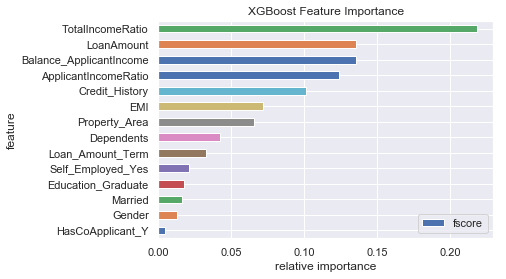

In [30]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import operator
create_feature_map(X_trainmodel)

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [31]:
test_y  =gbm.predict(xgb.DMatrix(test_X))

In [32]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="LoanAV_XgBooost"+timestamp+"_out.csv"

In [33]:
#submission.to_csv(filename)

In [53]:
xgb_clf = XGBClassifier(n_estimators=100, silent=False)
n_estimators = [10,20,30,40,50]
max_depth = [2, 4, 6, 8,10]
subsample=[0.2,0.4,0.6,0.8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_trainmodel ,y_trainmodel.values.ravel())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


In [54]:

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.460461 using {'max_depth': 2, 'n_estimators': 50, 'subsample': 0.6}
-0.517814 (0.028676) with: {'max_depth': 2, 'n_estimators': 10, 'subsample': 0.2}
-0.505343 (0.037280) with: {'max_depth': 2, 'n_estimators': 10, 'subsample': 0.4}
-0.501985 (0.039243) with: {'max_depth': 2, 'n_estimators': 10, 'subsample': 0.6}
-0.498827 (0.041255) with: {'max_depth': 2, 'n_estimators': 10, 'subsample': 0.8}
-0.485184 (0.045276) with: {'max_depth': 2, 'n_estimators': 20, 'subsample': 0.2}
-0.475706 (0.053954) with: {'max_depth': 2, 'n_estimators': 20, 'subsample': 0.4}
-0.471022 (0.056369) with: {'max_depth': 2, 'n_estimators': 20, 'subsample': 0.6}
-0.470181 (0.062029) with: {'max_depth': 2, 'n_estimators': 20, 'subsample': 0.8}
-0.483992 (0.051496) with: {'max_depth': 2, 'n_estimators': 30, 'subsample': 0.2}
-0.465648 (0.056626) with: {'max_depth': 2, 'n_estimators': 30, 'subsample': 0.4}
-0.461619 (0.062585) with: {'max_depth': 2, 'n_estimators': 30, 'subsample': 0.6}
-0.466009 (0.068261) 

In [56]:
best_estimator =grid_result.best_estimator_
print(best_estimator)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.6)


In [57]:
colsample_bytree=[0.2,0.4,0.6,0.8]
colsample_bylevel=[0.2,0.4,0.6,0.8]
param_grid = dict(colsample_bylevel=colsample_bylevel,colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(best_estimator, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_trainmodel ,y_trainmodel.values.ravel())

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   25.7s finished


In [58]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.463037 using {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8}
-0.530133 (0.046309) with: {'colsample_bylevel': 0.2, 'colsample_bytree': 0.2}
-0.530674 (0.043842) with: {'colsample_bylevel': 0.2, 'colsample_bytree': 0.4}
-0.520139 (0.034768) with: {'colsample_bylevel': 0.2, 'colsample_bytree': 0.6}
-0.495733 (0.055959) with: {'colsample_bylevel': 0.2, 'colsample_bytree': 0.8}
-0.530133 (0.046309) with: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.2}
-0.488652 (0.048150) with: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.4}
-0.483955 (0.049520) with: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.6}
-0.470195 (0.058264) with: {'colsample_bylevel': 0.4, 'colsample_bytree': 0.8}
-0.530133 (0.046309) with: {'colsample_bylevel': 0.6, 'colsample_bytree': 0.2}
-0.478611 (0.052727) with: {'colsample_bylevel': 0.6, 'colsample_bytree': 0.4}
-0.474402 (0.055560) with: {'colsample_bylevel': 0.6, 'colsample_bytree': 0.6}
-0.470838 (0.062886) with: {'colsample_bylevel': 0.6, 'co

In [59]:
best_estimator =grid_result.best_estimator_

In [60]:
test_y  =best_estimator.predict(test_X)
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="LoanAV_XgBooost"+timestamp+"_out.csv"
submission.to_csv(filename)